Updated Code

In [ ]:
import os
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture

# Function to extract 7x7 patches from an image with a shift of 1 pixel
def extract_patches(image):
    patches = []
    for i in range(0, image.shape[0] - 6):
        for j in range(0, image.shape[1] - 6):
            patch = image[i:i+7, j:j+7]
            mean_intensity = np.mean(patch)
            variance_intensity = np.var(patch)
            feature_vector = np.array([mean_intensity, variance_intensity])
            patches.append(feature_vector)
    return patches

# Process training images and extract feature vectors
train_folder = '/content/drive/MyDrive/SceneData/cellData/Train'
training_feature_vectors = []
for image_file in os.listdir(train_folder):
    image_path = os.path.join(train_folder, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        patches = extract_patches(image)
        training_feature_vectors.extend(patches)
    else:
        print(f"Error loading image: {image_path}")

# Stack 2D feature vectors into a single numpy array for training
training_data = np.array(training_feature_vectors)

# Number of clusters (you can adjust this)
k = 3

# Initialize and train Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=k, covariance_type='full')
gmm.fit(training_data)

# Process test images and extract feature vectors
test_folder = '/content/drive/MyDrive/SceneData/cellData/Test'
test_feature_vectors = []
for test_image_file in os.listdir(test_folder):
    test_image_path = os.path.join(test_folder, test_image_file)
    test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    if test_image is not None:
        test_patches = extract_patches(test_image)
        test_feature_vectors.extend(test_patches)
    else:
        print(f"Error loading test image: {test_image_path}")

# Stack 2D feature vectors for test data into a single numpy array
test_data = np.array(test_feature_vectors)

# Predict cluster labels for test data using the trained GMM
predicted_labels = gmm.predict(test_data)

# 'predicted_labels' now contains the cluster assignments for each test feature vector
# You can use these cluster assignments for further analysis or classification.


In [ ]:
# Load a sample test image to determine its shape
sample_test_image_path = '/content/drive/MyDrive/SceneData/cellData/Test/52.png'
sample_test_image = cv2.imread(sample_test_image_path, cv2.IMREAD_GRAYSCALE)

# Get the shape of the sample test image
test_image_shape = sample_test_image.shape



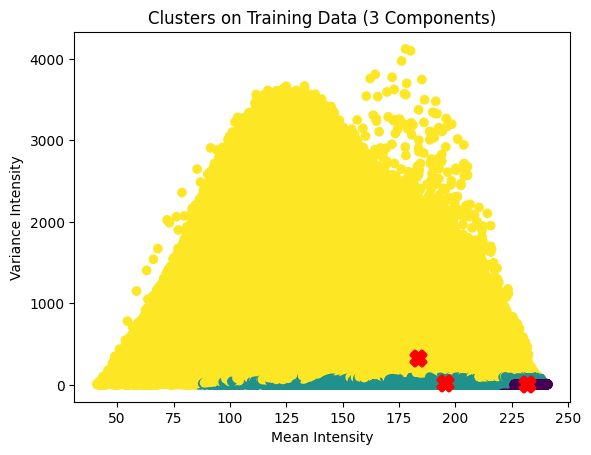

NameError: ignored

In [ ]:
# Train GMM with 3 components
gmm_3_components = GaussianMixture(n_components=3, covariance_type='full')
log_likelihood_3_components = []  # List to store log-likelihood values during training
for i in range(1, 11):  # Train for a maximum of 10 iterations
    gmm_3_components.fit(training_data)
    log_likelihood_3_components.append(gmm_3_components.score(training_data))

# Plotting 3 Clusters on Training Data
plt.scatter(training_data[:, 0], training_data[:, 1], c=gmm_3_components.predict(training_data), cmap='viridis')
plt.scatter(gmm_3_components.means_[:, 0], gmm_3_components.means_[:, 1], marker='X', s=100, linewidths=3, color='r')
plt.title('Clusters on Training Data (3 Components)')
plt.xlabel('Mean Intensity')
plt.ylabel('Variance Intensity')
plt.show()



In [ ]:
# Define cluster colors for visualization (you can modify these colors as needed)
cluster_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red, Green, Blue


In [ ]:

# Segmentation of Test Images using Trained GMM
test_labels = gmm_3_components.predict(test_data)
segmented_images = []
for i, label in enumerate(test_labels):
    x = i % (test_image_shape[1] - 6)
    y = i // (test_image_shape[1] - 6)
    color = cluster_colors[label]
    segmented_image = np.zeros((7, 7, 3), dtype=np.uint8)
    segmented_image[:, :] = color
    segmented_images.append((x, y, segmented_image))



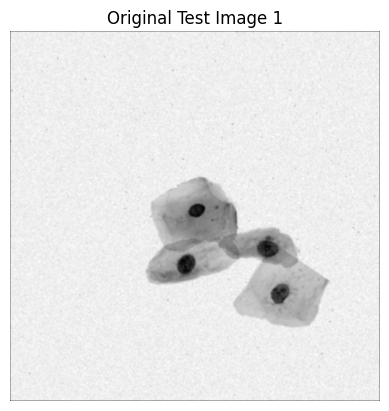

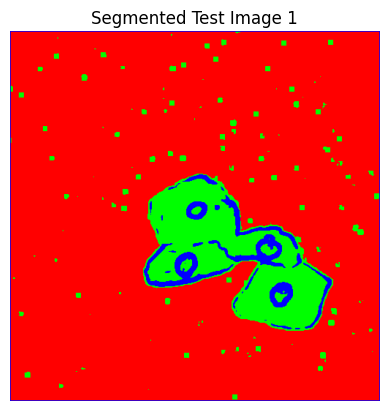

In [ ]:
# Define cluster colors (for example, red, green, and blue)
cluster_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

# Load Test Image 1
test_image_path1 = '/content/drive/MyDrive/SceneData/cellData/Test/57.png'
test_image1 = cv2.imread(test_image_path1, cv2.IMREAD_GRAYSCALE)

# Overlay segmentation results onto Test Image 1 with cluster colors
segmented_image = np.zeros((test_image1.shape[0]-6, test_image1.shape[1]-6, 3), dtype=np.uint8)
for i, label in enumerate(test_labels):
    x = i % (test_image1.shape[1] - 6)
    y = i // (test_image1.shape[1] - 6)
    color = cluster_colors[label]
    segmented_image[y:y+7, x:x+7] = color

# Display original Test Image 1
plt.imshow(test_image1, cmap='gray')
plt.title('Original Test Image 1')
plt.axis('off')
plt.show()

# Display segmented Test Image 1
plt.imshow(segmented_image)
plt.title('Segmented Test Image 1')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Custom implementation of multivariate normal PDF
def multivariate_normal_pdf(x, mean, covariance):
    """
    Compute the probability density function of a multivariate normal distribution.

    Parameters:
        x (numpy.ndarray): Input data points (features).
        mean (numpy.ndarray): Mean vector of the distribution.
        covariance (numpy.ndarray): Covariance matrix of the distribution.

    Returns:
        numpy.ndarray: Probability density values for each input data point.
    """
    # Compute the determinant and inverse of the covariance matrix
    det_covariance = np.linalg.det(covariance)
    inv_covariance = np.linalg.inv(covariance)

    # Compute the exponent term of the multivariate normal PDF
    exponent = -0.5 * np.dot(np.dot((x - mean).T, inv_covariance), (x - mean))

    # Compute the normalization constant
    normalization = 1 / ((2 * np.pi) ** (len(mean) / 2) * det_covariance ** 0.5)

    # Compute the final PDF values
    pdf_values = normalization * np.exp(exponent)

    return pdf_values

# Custom implementation of Gaussian Mixture Model (GMM) using EM algorithm
class CustomGMM:
    def __init__(self, num_components, max_iterations=100, tolerance=1e-4):
        self.num_components = num_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance

    def initialize_parameters(self, data):
        # Randomly initialize means and covariances
        np.random.seed(0)
        indices = np.random.choice(data.shape[0], self.num_components, replace=False)
        self.means = data[indices]
        self.covariances = [np.eye(data.shape[1]) for _ in range(self.num_components)]
        self.weights = np.ones(self.num_components) / self.num_components

    def expectation_step(self, data):
        responsibilities = np.zeros((len(data), self.num_components))
        for i in range(self.num_components):
            responsibilities[:, i] = self.weights[i] * multivariate_normal_pdf(data, self.means[i], self.covariances[i])
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        return responsibilities

    def maximization_step(self, data, responsibilities):
        N_k = np.sum(responsibilities, axis=0)
        self.weights = N_k / len(data)
        self.means = np.dot(responsibilities.T, data) / N_k[:, np.newaxis]
        for i in range(self.num_components):
            diff = data - self.means[i]
            self.covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / N_k[i]

    def fit(self, data):
        self.initialize_parameters(data)
        prev_log_likelihood = None
        for iteration in range(self.max_iterations):
            responsibilities = self.expectation_step(data)
            self.maximization_step(data, responsibilities)
            # Compute log-likelihood
            log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1)))
            # Check for convergence
            if prev_log_likelihood is not None and np.abs(log_likelihood - prev_log_likelihood) < self.tolerance:
                break
            prev_log_likelihood = log_likelihood

    def predict(self, data):
        responsibilities = self.expectation_step(data)
        return np.argmax(responsibilities, axis=1)

# Generate synthetic data for demonstration
np.random.seed(0)
data1 = np.random.multivariate_normal(mean=[3, 3], cov=[[1, 0.5], [0.5, 1]], size=100)
data2 = np.random.multivariate_normal(mean=[7, 7], cov=[[1, -0.7], [-0.7, 1]], size=100)
data3 = np.random.multivariate_normal(mean=[11, 3], cov=[[1, 0], [0, 1]], size=100)
data = np.concatenate([data1, data2, data3])

# Instantiate and fit the custom GMM
num_components = 3
custom_gmm = CustomGMM(num_components)
custom_gmm.fit(data)

# Predict clusters for the data points
predicted_labels = custom_gmm.predict(data)

# Visualize clusters
plt.scatter(data[:, 0], data[:, 1], c=predicted_labels, cmap='viridis')
plt.scatter(custom_gmm.means[:, 0], custom_gmm.means[:, 1], marker='X', s=100, linewidths=3, color='r')
plt.title('Custom GMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


#Scratch GMM

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Function to extract 7x7 patches from an image with a shift of 1 pixel
def extract_patches(image):
    patches = []
    for i in range(0, image.shape[0] - 6):
        for j in range(0, image.shape[1] - 6):
            patch = image[i:i+7, j:j+7]
            mean_intensity = np.mean(patch)
            variance_intensity = np.var(patch)
            feature_vector = np.array([mean_intensity, variance_intensity])
            patches.append(feature_vector)
    return patches

# Function to initialize GMM parameters
def initialize_parameters(data, k):
    # Randomly initialize means and covariances
    np.random.seed(0)
    means = data[np.random.choice(data.shape[0], k, replace=False)]
    covariances = [np.eye(data.shape[1]) for _ in range(k)]  # Initialize as identity matrices
    weights = np.ones(k) / k
    return means, covariances, weights

# Function to compute responsibilities (E-step)
def compute_responsibilities(data, means, covariances, weights, k):
    responsibilities = np.zeros((len(data), k))
    for i in range(k):
        multivariate_normal_pdf = multivariate_normal.pdf(data, mean=means[i], cov=covariances[i])
        responsibilities[:, i] = multivariate_normal_pdf * weights[i]
    responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
    return responsibilities

# Function to update GMM parameters (M-step)
def update_parameters(data, responsibilities, k):
    N_k = np.sum(responsibilities, axis=0)
    weights = N_k / len(data)
    means = np.dot(responsibilities.T, data) / N_k[:, np.newaxis]
    covariances = []
    for i in range(k):
        diff = data - means[i]
        covariances.append(np.dot(responsibilities[:, i] * diff.T, diff) / N_k[i])
    return means, covariances, weights

# Function to perform GMM clustering
def gmm(data, k, max_iterations=10, tolerance=1e-4):
    means, covariances, weights = initialize_parameters(data, k)
    for iteration in range(max_iterations):
        old_means, old_covariances, old_weights = means.copy(), covariances.copy(), weights.copy()
        responsibilities = compute_responsibilities(data, means, covariances, weights, k)
        means, covariances, weights = update_parameters(data, responsibilities, k)
        # Check for convergence
        if np.allclose(means, old_means, atol=tolerance) and np.allclose(covariances, old_covariances, atol=tolerance) and np.allclose(weights, old_weights, atol=tolerance):
            break
    return responsibilities, means, covariances, weights

# Load and process data
train_folder = '/content/drive/MyDrive/SceneData/cellData/Train'
training_feature_vectors = []
for image_file in os.listdir(train_folder):
    image_path = os.path.join(train_folder, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        patches = extract_patches(image)
        training_feature_vectors.extend(patches)
    else:
        print(f"Error loading image: {image_path}")

training_data = np.array(training_feature_vectors)

# Perform GMM clustering
k = 3
responsibilities, means, covariances, weights = gmm(training_data, k)

# Process test images
test_folder = '/content/drive/MyDrive/SceneData/cellData/Test'
test_feature_vectors = []
for test_image_file in os.listdir(test_folder):
    test_image_path = os.path.join(test_folder, test_image_file)
    test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    if test_image is not None:
        test_patches = extract_patches(test_image)
        test_feature_vectors.extend(test_patches)
    else:
        print(f"Error loading test image: {test_image_path}")

test_data = np.array(test_feature_vectors)

# Assign test feature vectors to clusters using GMM
test_responsibilities = compute_responsibilities(test_data, means, covariances, weights, k)
test_labels = np.argmax(test_responsibilities, axis=1)

# Visualize clusters projected on test data
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap='viridis')
plt.scatter(means[:, 0], means[:, 1], marker='X', s=100, linewidths=3, color='r')
plt.title('Cluster Projection on Test Data using GMM')
plt.xlabel('Mean Intensity')
plt.ylabel('Variance Intensity')
plt.show()

# Define cluster colors for visualization (you can modify these colors as needed)
cluster_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

# Overlay segmentation results onto test images
for i, label in enumerate(test_labels):
    x = i % (test_image_shape[1] - 6)
    y = i // (test_image_shape[1] - 6)
    color = cluster_colors[label]
    segmented_image = np.zeros((7, 7, 3), dtype=np.uint8)
    segmented_image[:, :] = color
    test_image[y:y+7, x:x+7] = segmented_image

# Display segmented test image
plt.imshow(test_image)
plt.title('Segmented Test Image (GMM Clusters)')
plt.axis('off')
plt.show()


<ipython-input-17-1d53299f0431>:34: RuntimeWarning: invalid value encountered in divide
  responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)


ValueError: ignored